In this notebook, SCOOT data (cycle level and 15min) is compared with the video counts done **on the same day at the same location**, with the ultimate goal of calibrating SCOOT data to be used as permanent count stations. 

All plots in the notebook represent counts on 2017-04-19.

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pg import DB
import configparser
import warnings
warnings.simplefilter('error',RuntimeWarning)
from scoot_utilities import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Database connection
CONFIG = configparser.ConfigParser()
CONFIG.read('db.cfg')
dbset = CONFIG['DBSETTINGS']
db = DB(dbname=dbset['database'],host=dbset['host'],user=dbset['user'],passwd=dbset['password'])

In [3]:
# Set up
# Set up the centrelines and detectors in the scope of this analysis
centrelines = [3304786,446523,30018925,30018925,1147201,1147201,1147026,1147466,8540609,8571185,11466484,1141946]
dir_bins = [1,-1,1,-1,1,-1,1,1,1,-1,1,-1]
sdetectors = [['\'N12921J1\'','\'N12921J2\''],['\'N12931A1\'','\'N12931A2\''],['\'N12821C1\'','\'N12821C2\'','\'N12821C3\''],['\'N12851G1\'','\'N12851G2\''],['\'N30431K1\'','\'N30431K2\''],['\'N30421B1\'','\'N30421B2\''],['\'N30611K1\'','\'N30611K2\''],['\'N30311D1\'','\'N30311D2\''],['\'N21521K1\''],['\'N21521H1\''],['\'N21421D1\''],['\'N21311B1\'']]
locations = ['Don Mills NB N of Overlea','Don Mills SB S of Gateway','Don Mills NB N of Clock Tower','Don Mills SB S of Lawrence','Lake Shore EB E of Stadium','Lake Shore WB W of Bathurst','Lake Shore EB E of Spadina','Lake Shore EB E of Ontario Place','Bloor EB W of Castle Frank','Bloor WB E of Castle Frank','Bloor EB E of Church','Bloor WB W of Church']
aggregation = [[['lane1','lane2'],['lane3']],
               [['lane1','lane2'],['lane3']],
               [['lane1'],['lane2'],['lane3']],
               [['lane2','lane3'],['lane1']],
               [['lane1','lane2'],['lane3']],
               [['lane3'],['lane1','lane2']],
               [['lane1'],['lane2','lane3']],
               [['lane1'],['lane2','lane3']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']],
               [['lane1','lane2']]]
det_lane = {'N12921J1':2,'N12921J2':1,'N12931A1':2,'N12931A2':1,'N12821C1':1,'N12821C2':1,'N12821C3':1,
                 'N12851G1':2,'N12851G2':1,'N30431K1':2,'N30431K2':1,'N30421B1':1,'N30421B2':2,'N30611K1':1,
                 'N30611K2':2,'N30311D1':1,'N30311D2':2,'N21521K1':2,'N21521H1':2,'N21421D1':2,'N21311B1':2}

In [4]:
# Retrieve Data from the database
scoot_disagg = pd.DataFrame(db.query('SELECT * FROM scoot.cycle_level_170419 WHERE detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), \
                            columns = ['count_date','count_time','detector','CycleTime','Volume','occupancy','seconds'])
video = pd.DataFrame(db.query('SELECT * FROM scoot.video_counts').getresult(), \
                     columns = ['time_start','time_end','lane1','lane2','lane3','Volume','centreline_id','dir_bin','count_date','seconds'])
video['CycleTime'] = 20
scoot_agg = pd.DataFrame(db.query('SELECT detector, start_time, flow_mean, EXTRACT(HOUR FROM start_time)*3600 + EXTRACT(MINUTE FROM start_time)*60 AS seconds  FROM scoot.agg_15_201704 WHERE start_time::date = \'2017-04-19\' AND detector IN (' + ','.join([y for x in sdetectors for y in x ]) + ')').getresult(), \
                         columns = ['detector', 'count_time', 'Volume', 'seconds'])
scoot_agg['Volume'] = scoot_agg['Volume']//4

In [5]:
# Parameters
# Video counts do not start until 15min into the day. will report error if 00:00:00 is entered as start time
start_hour = 0
start_min = 15
start_sec = 0
end_hour = 23
end_min = 59
end_sec = 59

offsets = [0,0,0,0,0,0,0,0,0,0,0,0]
bin_sec = 900

start_time_sec = start_hour * 3600 + start_min * 60 + start_sec
end_time_sec = end_hour * 3600 + end_min * 60 + end_sec
num_bins = (end_time_sec - start_time_sec)//bin_sec
min_bins_start_15 = list(np.linspace(start_time_sec, start_time_sec+bin_sec*num_bins, num_bins+1))
bins = [x//bin_sec for x in min_bins_start_15]
bins = bins[:-1]

Four models are fitted to the data:
1. Linear Hybrid Exponential  
    Piecewise function, fit linear until a threshold and fit exponential to the rest.
2. Linear
3. Quadratic
4. Linear Hybrid Quadratic  
    Piecewise function, fit linear until a threshold and fit quadratic to the rest.
    
The hybrid models were only fitted to the 2-lane detectors as the 1-lane detectors should exhibit linear behavior.

* In the first row of plots (disaggregate scoot), red data points (> 3 * video count OR < 1/3 video count) are treated like outliers and are not fitted.

Don Mills NB N of Overlea


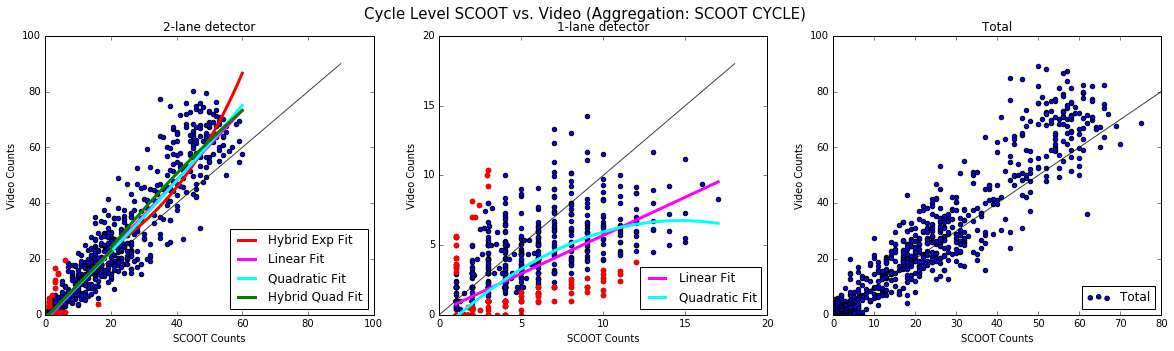

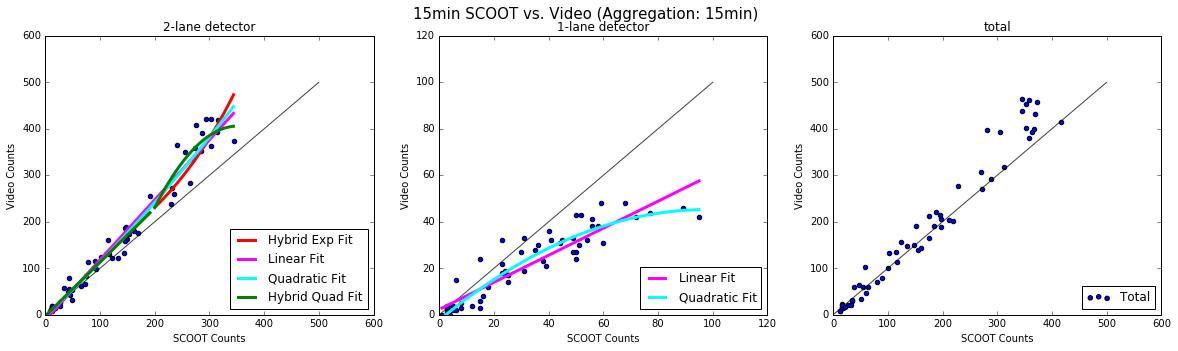

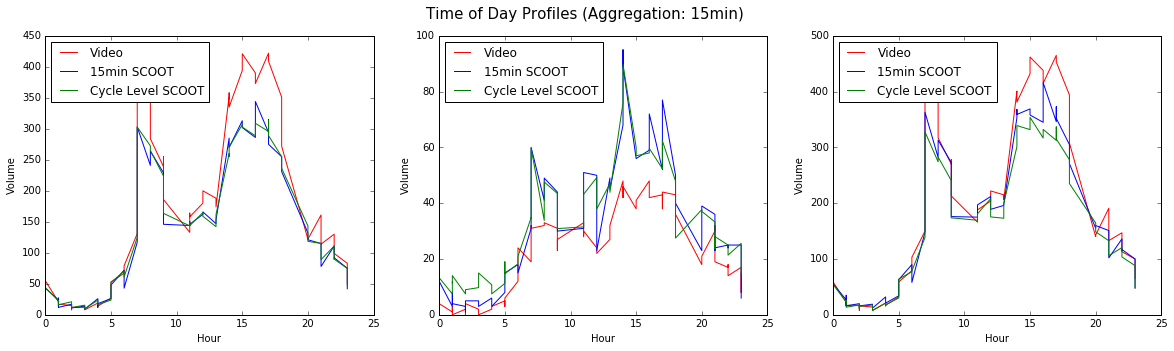

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3768.12  3636.97    3619.00       3622.99
                aggregate         1058.74  1089.39    1030.11        984.37
1-lane detector disaggregate          NaN  1152.34    1109.41           NaN
                aggregate             NaN   290.95     230.75           NaN



Don Mills SB S of Gateway


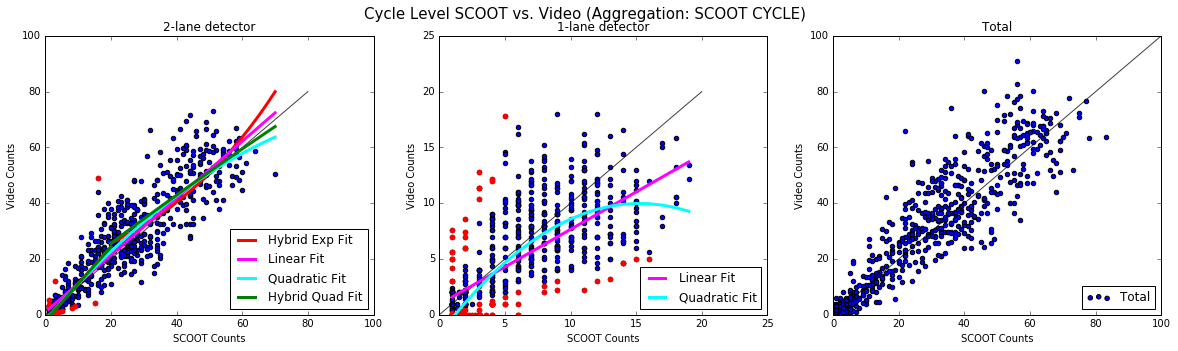

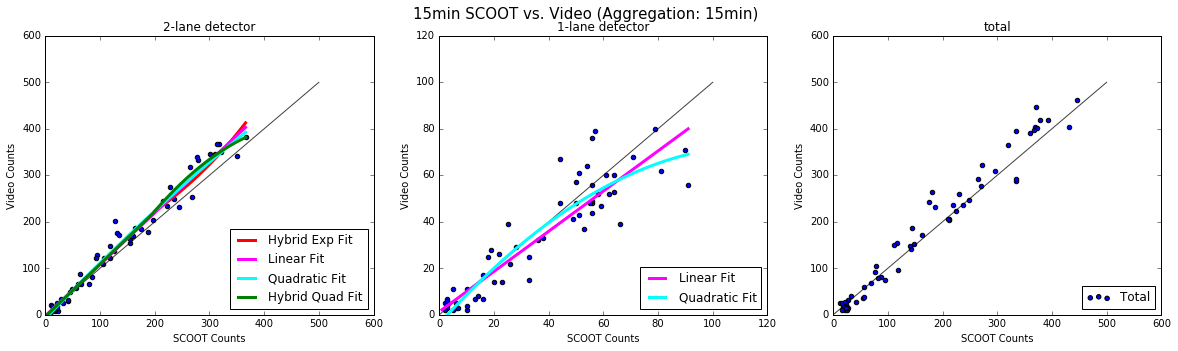

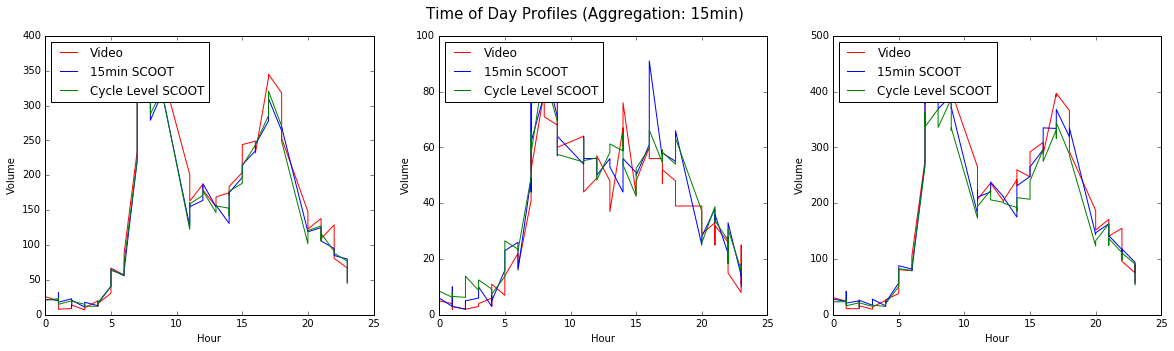

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3398.20  3459.00    3365.64       3389.69
                aggregate          865.13   817.25     811.50        770.91
1-lane detector disaggregate          NaN  1496.21    1379.67           NaN
                aggregate             NaN   417.93     416.85           NaN



Don Mills NB N of Clock Tower


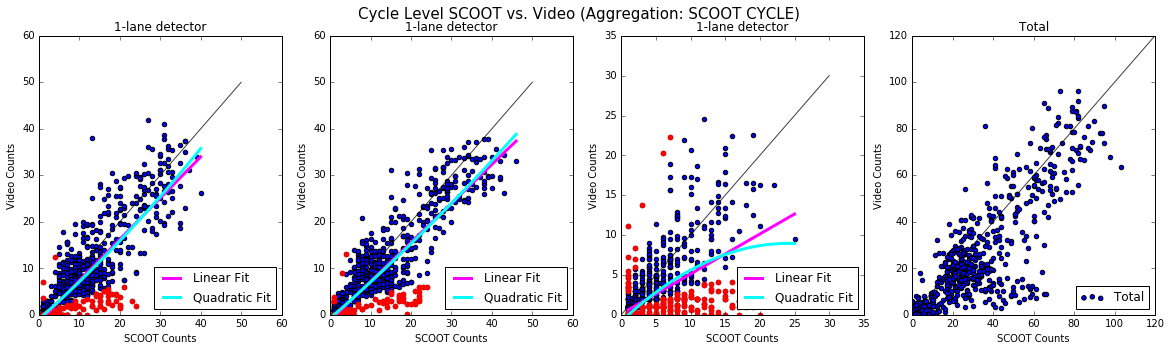

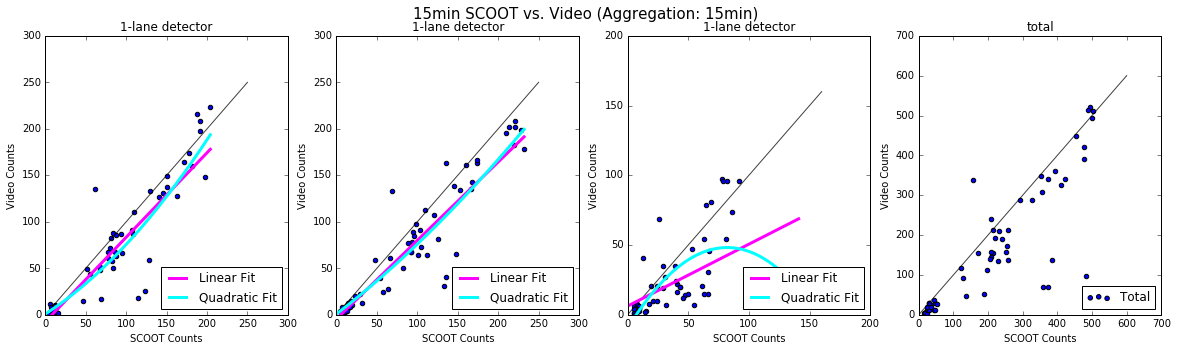

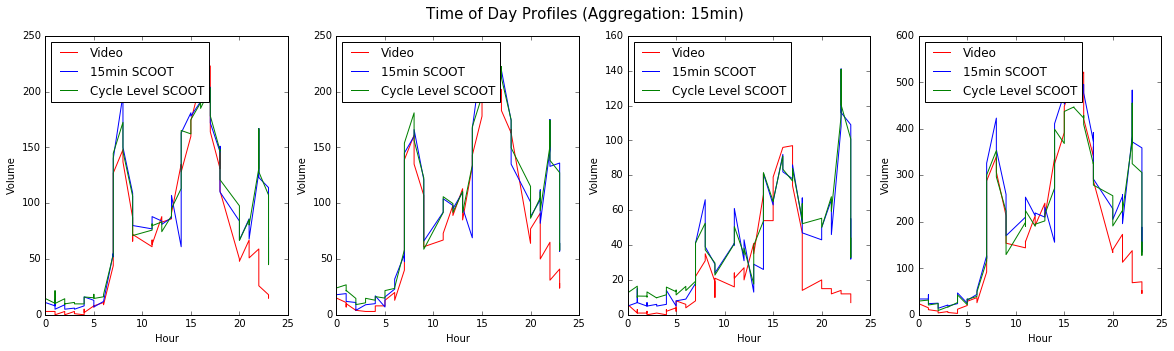

Sum of Absolute Error:
                             Lin hyd Exp   Linear  Quadratic Lin hyd Quad
Detector        Source                                                   
1-lane detector disaggregate        None  2538.29    2562.59         None
                aggregate           None  1003.28     987.32         None
                disaggregate        None  2354.65    2361.98         None
                aggregate           None   988.26     976.68         None
                disaggregate        None  1836.09    1817.68         None
                aggregate           None  1013.50     875.19         None



Don Mills SB S of Lawrence


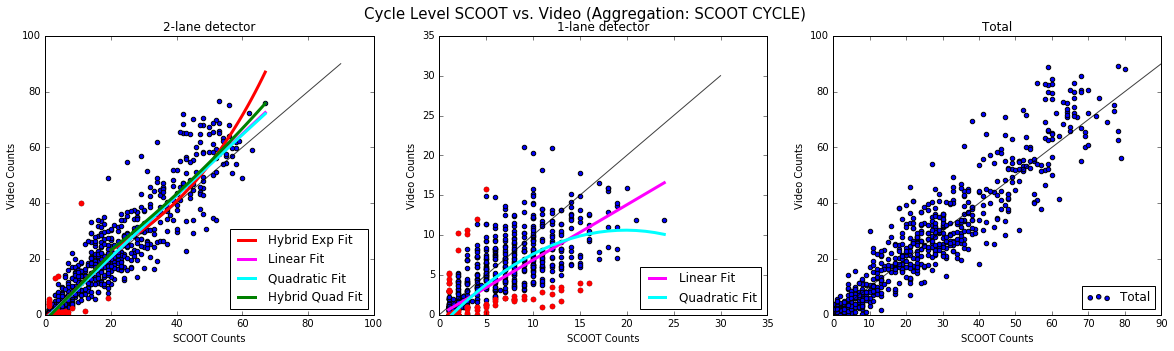

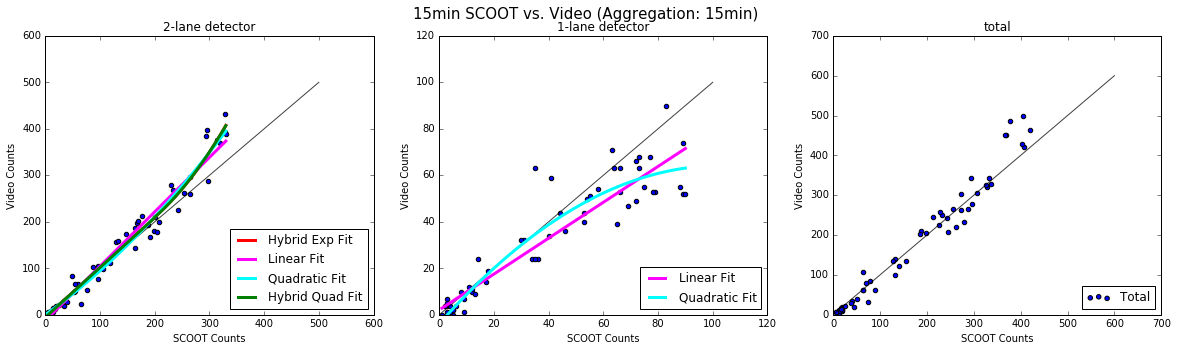

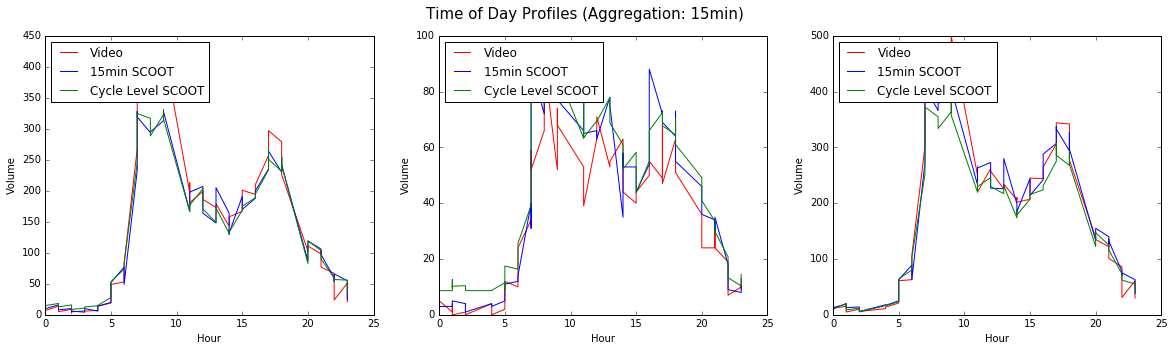

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3501.49  3426.42    3423.92       3457.10
                aggregate          928.62  1077.80     932.70        927.65
1-lane detector disaggregate          NaN  1582.01    1490.04           NaN
                aggregate             NaN   402.37     367.16           NaN



Lake Shore EB E of Stadium


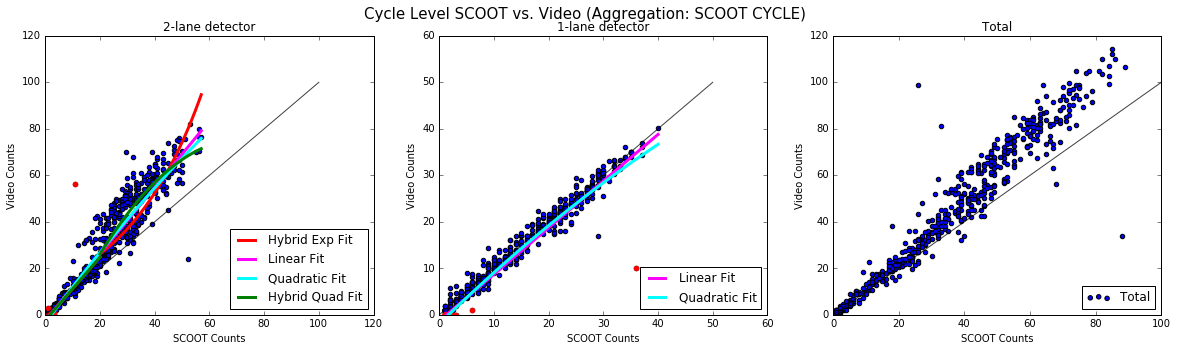

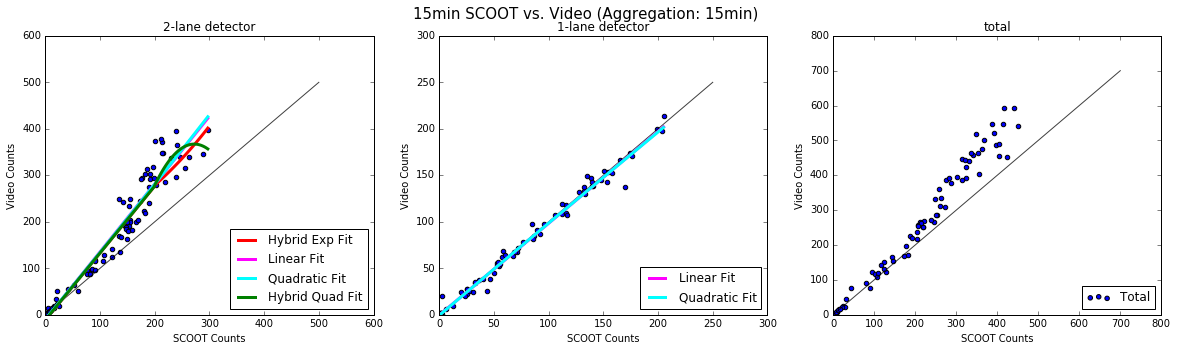

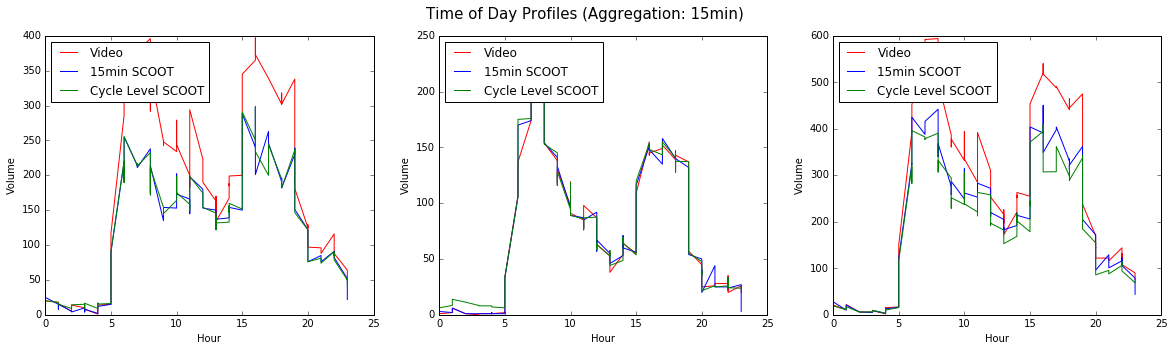

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      2898.87  2680.98    2755.32       2576.01
                aggregate         1992.28  2051.74    2030.90       1951.20
1-lane detector disaggregate          NaN   636.37     600.28           NaN
                aggregate             NaN   315.51     313.05           NaN



Lake Shore WB W of Bathurst


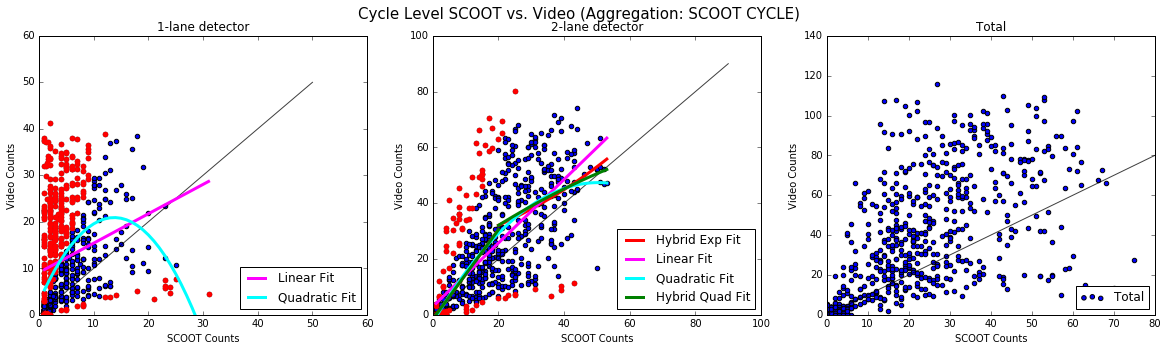

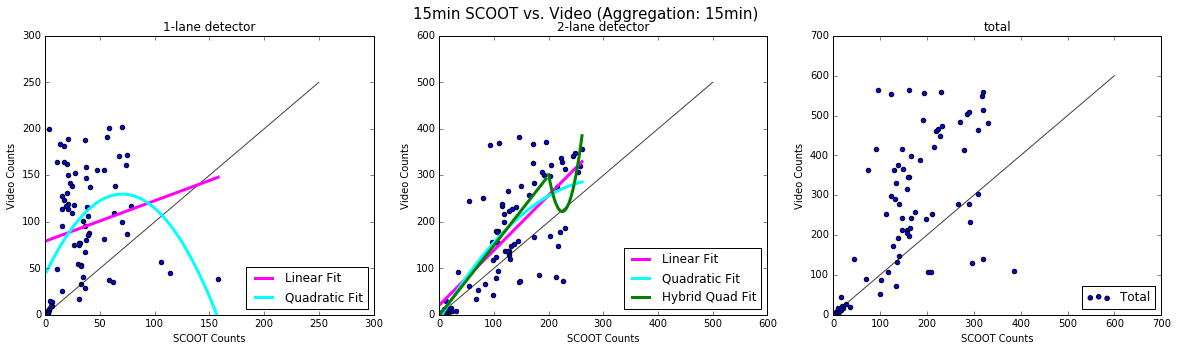

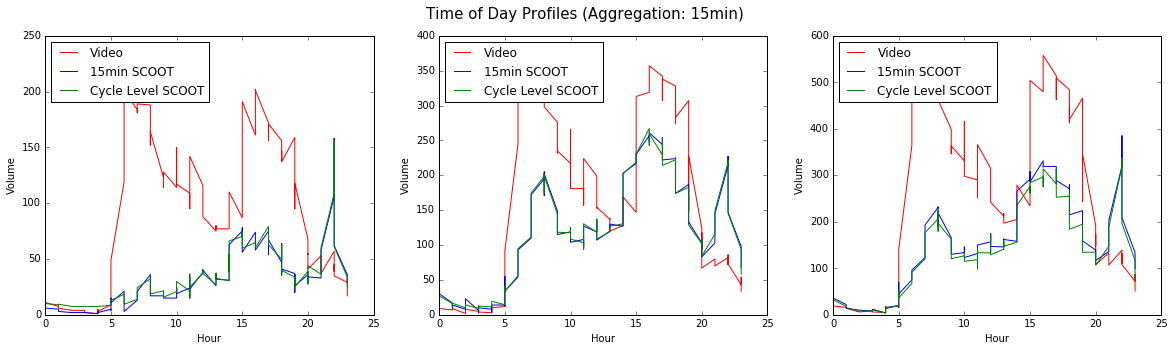

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
1-lane detector disaggregate          NaN  5869.19    5443.13           NaN
                aggregate             NaN  4056.51    3702.76           NaN
2-lane detector disaggregate      6718.57  7135.71    6663.85       6704.82
                aggregate             NaN  5060.51    4890.81       4662.12



Lake Shore EB E of Spadina


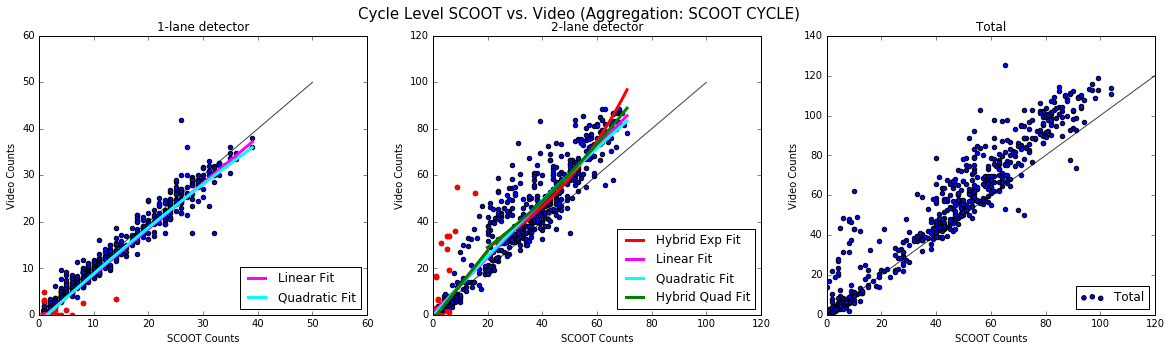

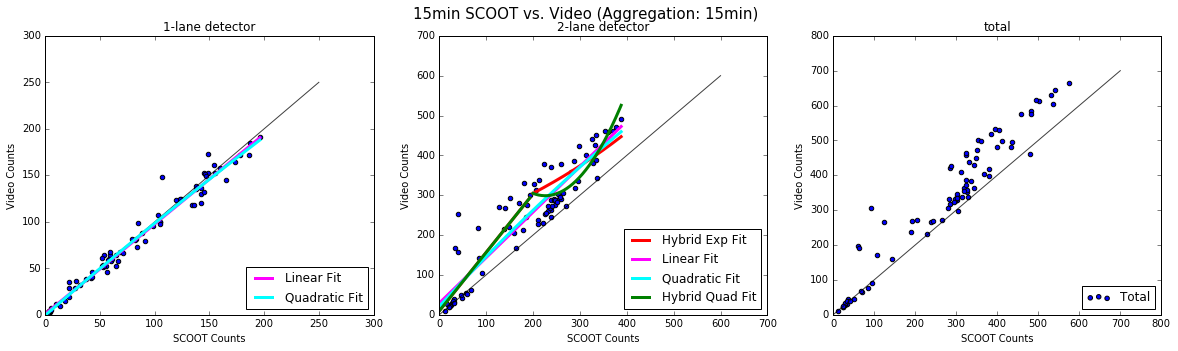

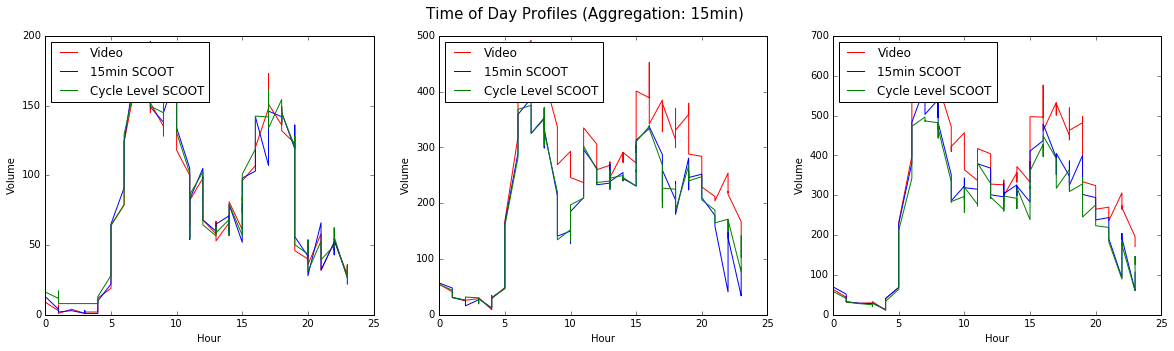

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
1-lane detector disaggregate          NaN   779.44     766.19           NaN
                aggregate             NaN   441.64     439.19           NaN
2-lane detector disaggregate      3629.81  3877.82    3870.33       3692.54
                aggregate         3590.09  3341.82    3357.63       3019.48



Lake Shore EB E of Ontario Place


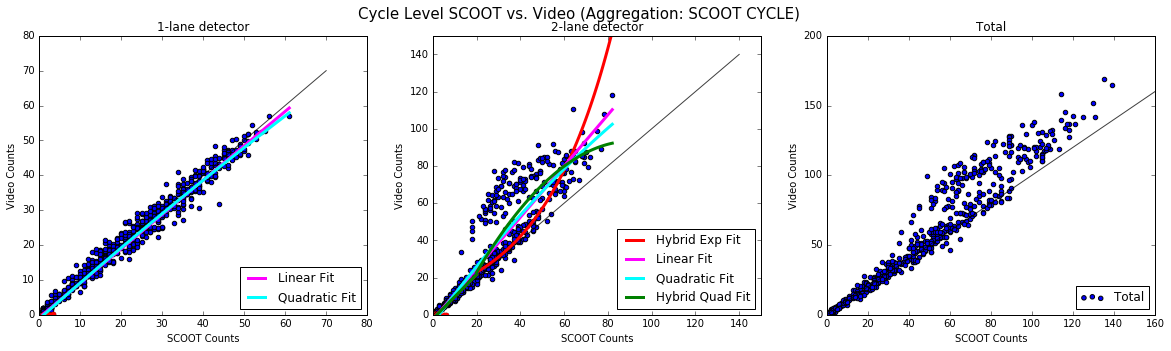

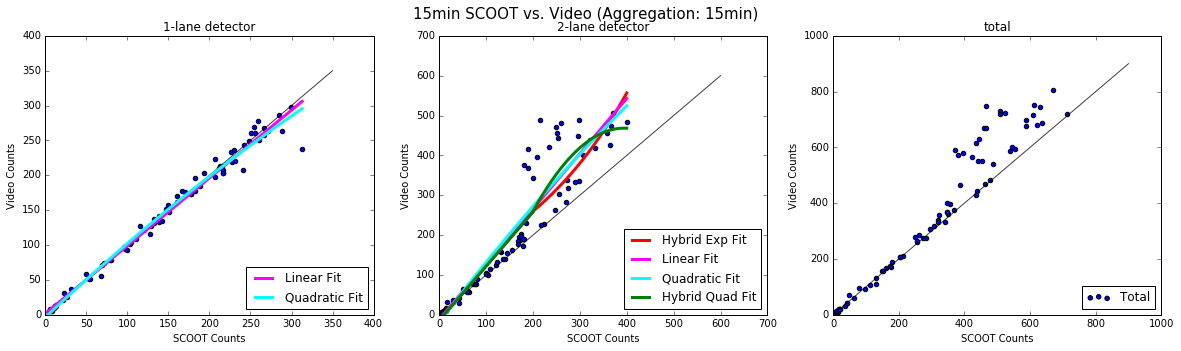

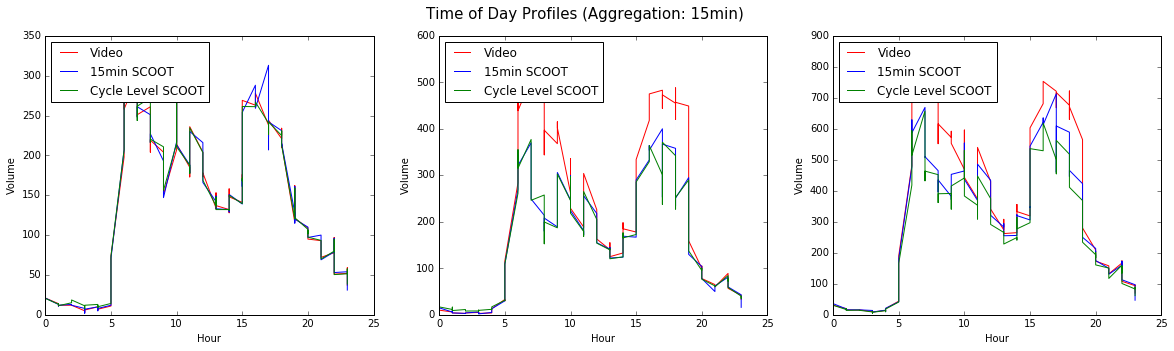

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
1-lane detector disaggregate          NaN   995.58     984.70           NaN
                aggregate             NaN   559.52     562.57           NaN
2-lane detector disaggregate      4382.85  4287.45    4484.21       4031.42
                aggregate         3262.06  3370.60    3531.50       3232.65



Bloor EB W of Castle Frank


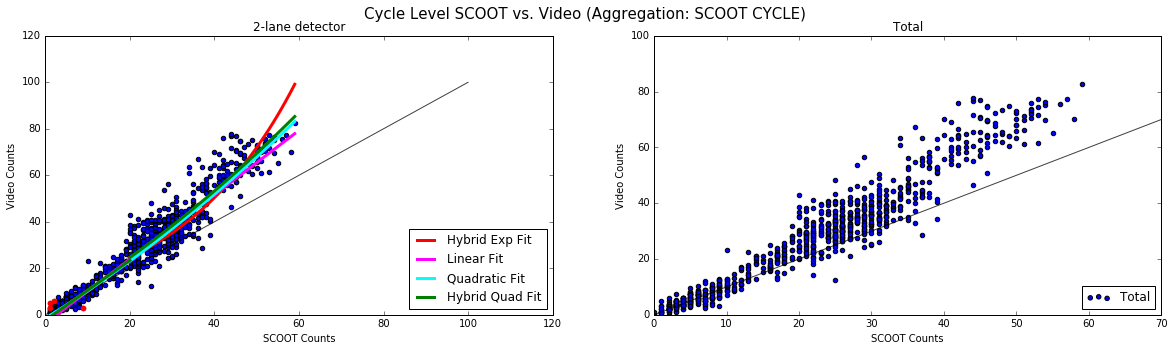

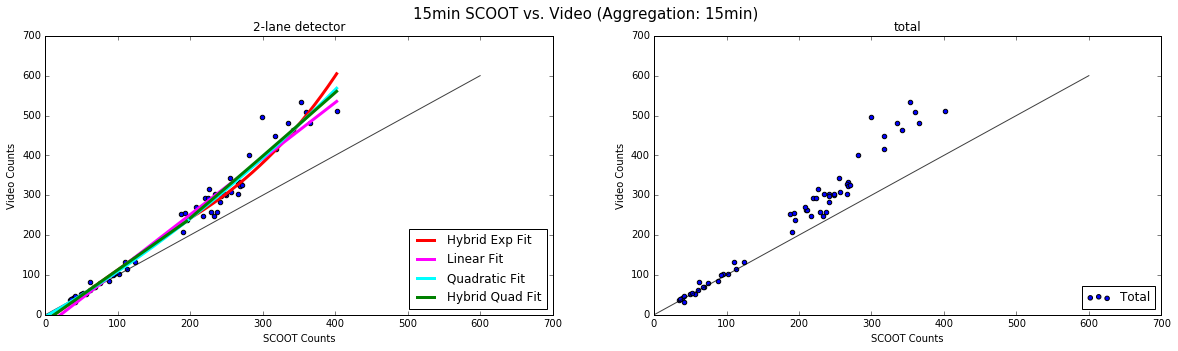

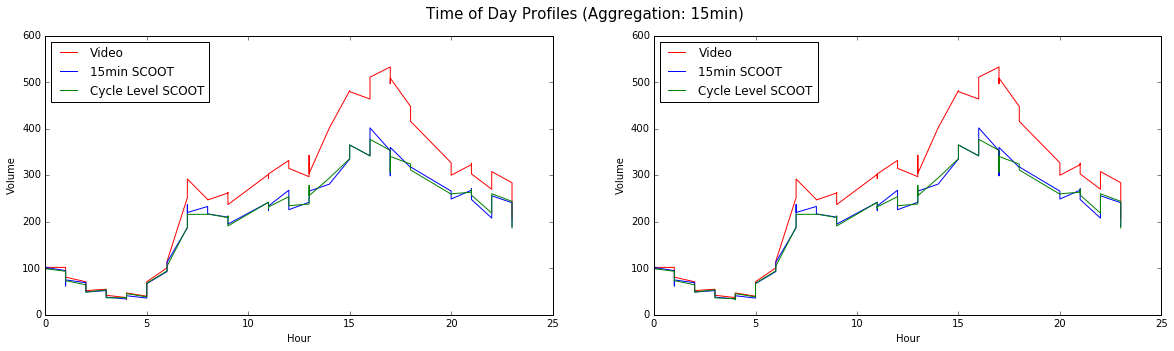

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3362.19  3310.05    3127.98       3152.93
                aggregate          987.44  1094.69     968.12       1016.24



Bloor WB E of Castle Frank


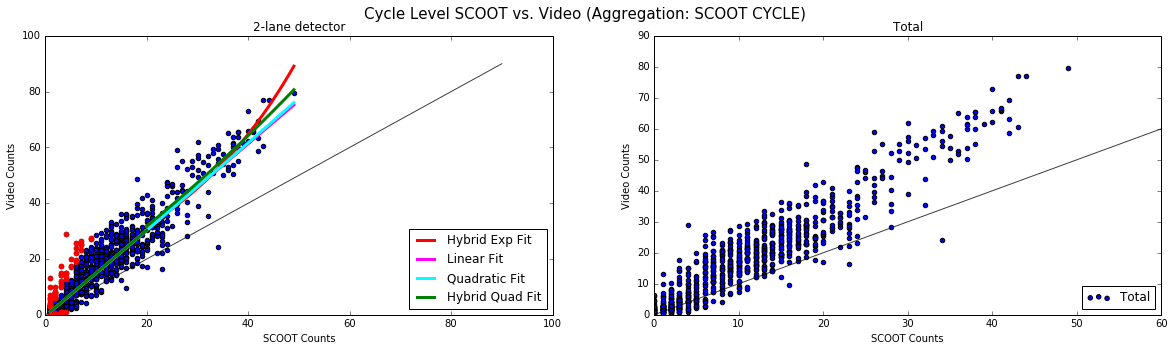

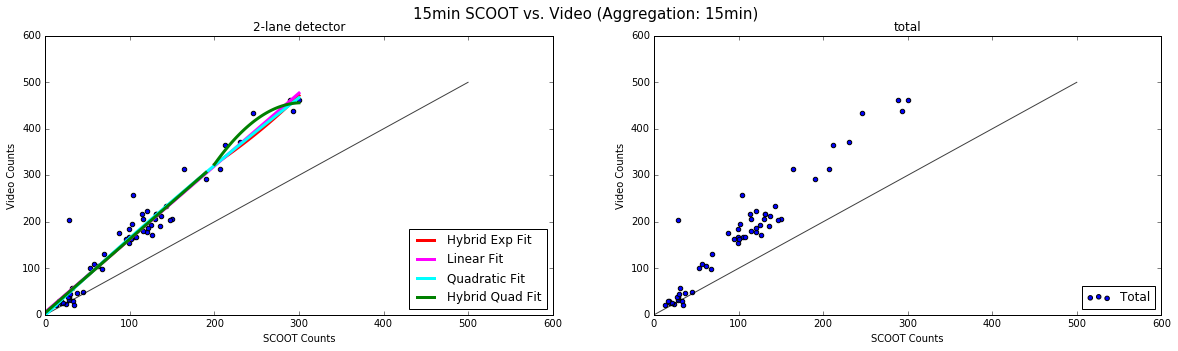

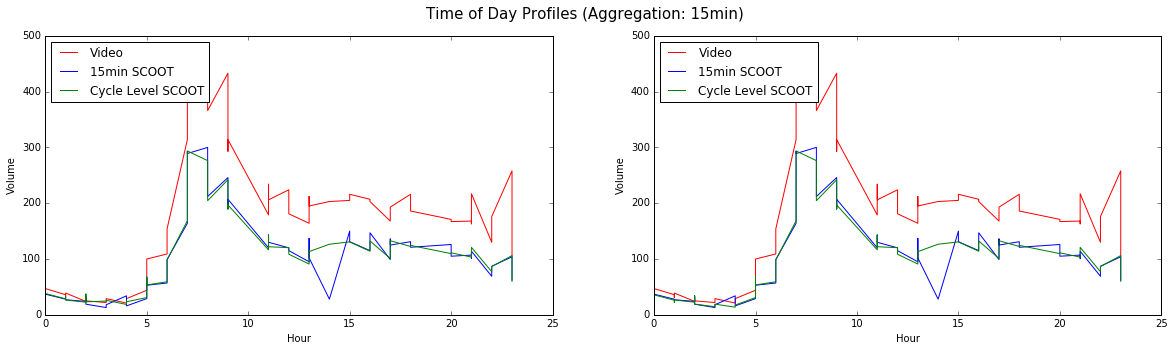

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3533.10  3502.04    3508.20       3503.61
                aggregate         1141.93  1139.82    1105.82       1106.48



Bloor EB E of Church


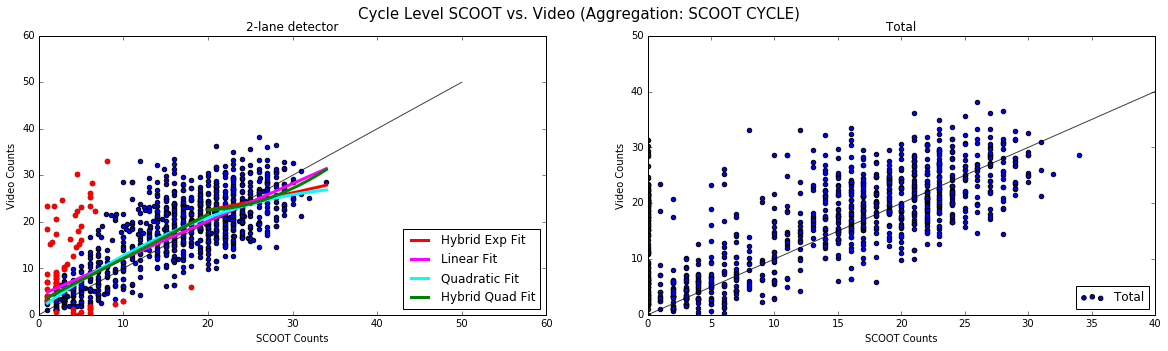

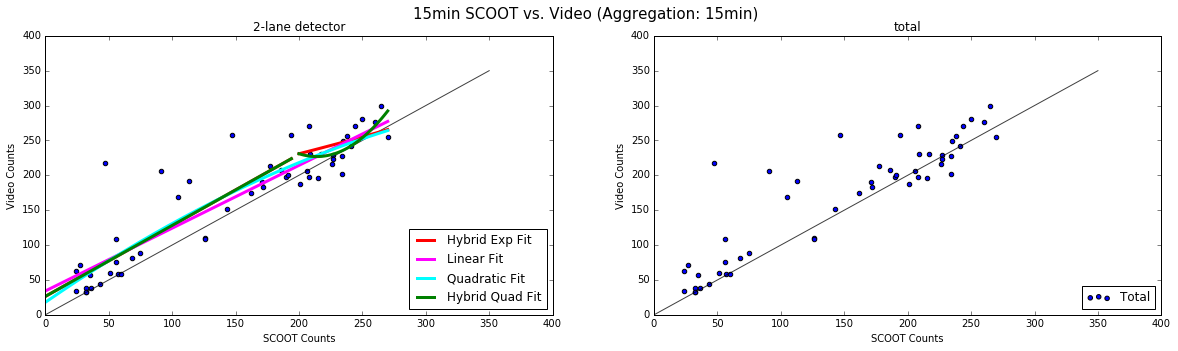

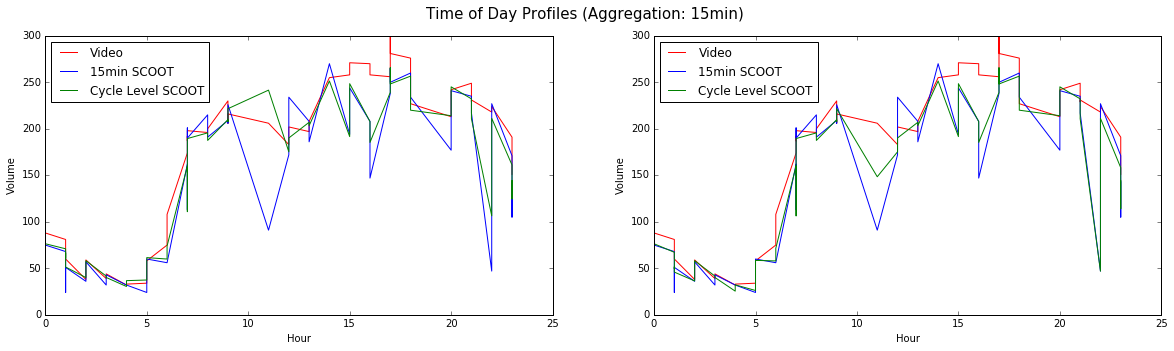

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      4170.27  4257.28    4136.91       4161.89
                aggregate         1420.66  1328.14    1339.91       1351.56



Bloor WB W of Church


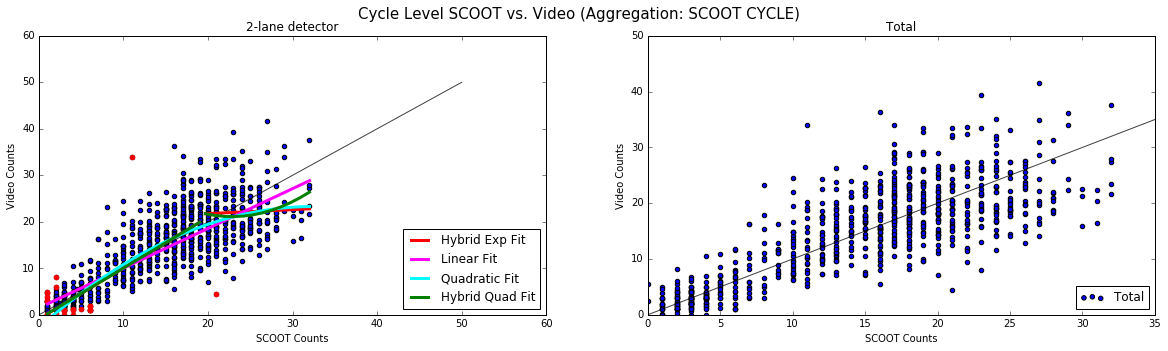

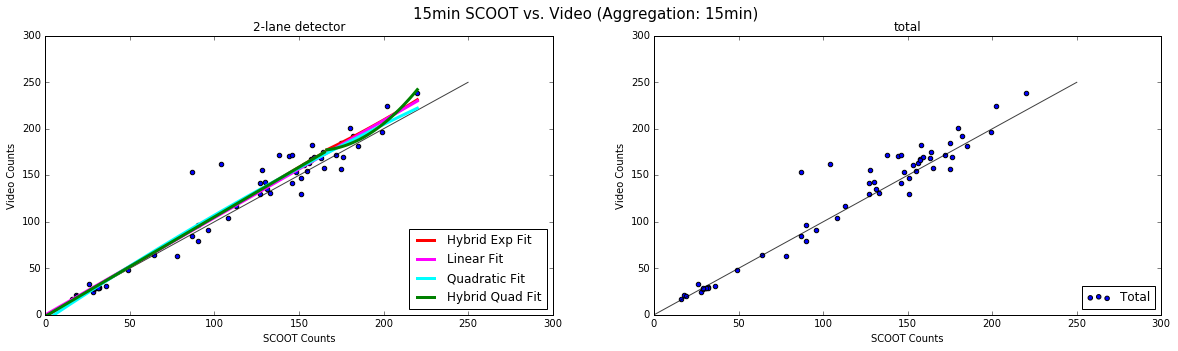

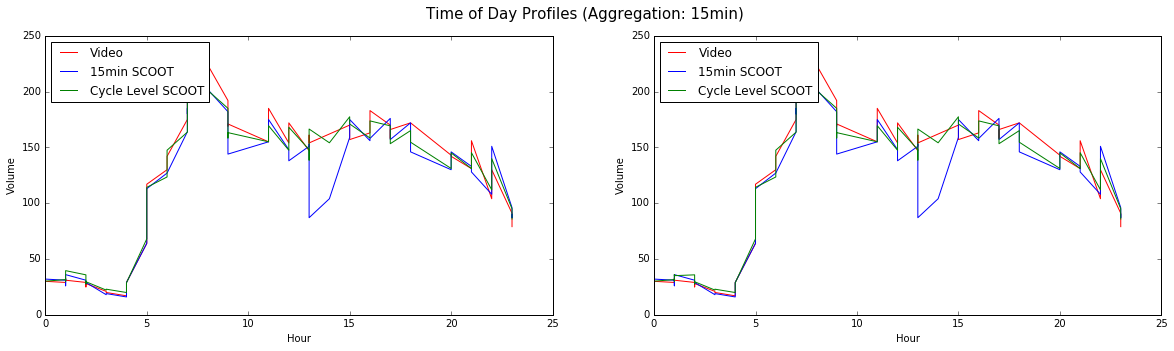

Sum of Absolute Error:
                              Lin hyd Exp   Linear  Quadratic  Lin hyd Quad
Detector        Source                                                     
2-lane detector disaggregate      3007.34  3181.24    2972.34       2995.43
                aggregate          567.92   563.53     577.83        561.63





In [11]:
for i in range(len(locations)):
    RSS = []
    sdet = [x.strip('\'') for x in sdetectors[i]]
    tcl = centrelines[i]
    dir_bin = dir_bins[i]
    offset = offsets[i]
    iterables = []
    
    print(locations[i])

    # Time Filter 
    s_d = scoot_disagg[(scoot_disagg['seconds']>=start_time_sec) & (scoot_disagg['seconds']+scoot_disagg['CycleTime']<=end_time_sec)].copy()
    s_d = s_d[s_d['detector'].isin([x.strip('\'') for x in sdet])]
    
    r = video[(video['seconds']>=start_time_sec-offset) & (video['seconds']<=end_time_sec-offset) & (video['centreline_id']==tcl) & (video['dir_bin']==dir_bin)].copy()
    r['bin'] = r['seconds']//bin_sec
    
    s_a = scoot_agg[(scoot_agg['seconds']>=start_time_sec) & (scoot_agg['seconds']+900<=end_time_sec)].copy()
    s_a = s_a[s_a['detector'].isin([x.strip('\'') for x in sdet])]
    
    # Aggregate lanes to individual detectors
    r = aggregate_lanes(r, aggregation[i])
    
    # Offset video counts
    r['seconds']=r['seconds']+offset

    # Reset Index
    s_d.reset_index(inplace=True, drop=True)
    r.reset_index(inplace=True, drop=True)
    s_a.reset_index(inplace=True, drop=True)
    
    # Create Figures
    fig,(ax) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # disaggregate vs video
    fig_a,(ax_a) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # aggregate vs video
    fig_tod, (ax_tod) = plt.subplots(1,len(sdet)+1,figsize=(20,5)) # time of day plots
    fig.suptitle('Cycle Level SCOOT vs. Video (Aggregation: SCOOT CYCLE)', fontsize=15)
    fig_a.suptitle('15min SCOOT vs. Video (Aggregation: 15min)', fontsize=15)
    fig_tod.suptitle('Time of Day Profiles (Aggregation: 15min)', fontsize=15)
    
    # Plot Individual Detectors
    for det in range(len(sdet)):
        # Disaggregate vs. Video
        s0_d = s_d[s_d['detector'] == sdet[det]].copy()
        
        # Validity Check
        if len(s0_d[s0_d['Volume'] != 0]) < 0.5*len(s0_d):
            print('Too Few Valid counts')
            continue
        
        # Get the timestamps of each bin
        min_bins_start = list(s0_d['seconds'])
        min_bins_start.append(s0_d['seconds'].values[-1]+s0_d['CycleTime'].values[-1])
        
        # Interpolate the missing values
        s1_d = fill_in_linear(list(s0_d['Volume']))
        # Aggregate video counts to scoot cycle level
        v = aggregate_data(min_bins_start, r, 'detector'+str(det))

        # Plot
        ax[det].scatter(s1_d, v, label=None)
        add_y_eq_x(ax[det])
        ax[det].set_title(str(det_lane[sdet[det]]) + '-lane detector')
        ax[det].set_ylabel('Video Counts')
        ax[det].set_xlabel('SCOOT Counts')
        ax[det].set_xlim(xmin = 0)
        ax[det].set_ylim(ymin = 0)
        
        # Mark counts that are too different (outliers)
        s2_d = [ax[det].scatter(a,b, color = 'r', label=None) for a,b in zip(s1_d, v) if (a>=3*b or b>=3*a)]

        step = min(np.percentile(v, 70), 20)
        # OPTION 1: LINEAR HYBRID WITH EXP
        if det_lane[sdet[det]] != 1:
            RSS_hybrid_exp = my_curve_fit(ax[det], s1_d, v, func_lin, func2=func_exp, step=step, color='red', fitname='Hybrid Exp Fit', p02=[9,0.0024])
        else:
            RSS_hybrid_exp = None
            
        # OPTION 2: LINEAR
        RSS_linear = my_curve_fit(ax[det], s1_d, v, func_lin, color='magenta', fitname='Linear Fit')
        
        # OPTION 3: QUADRATIC
        RSS_quad = my_curve_fit(ax[det], s1_d, v, func_quad, color='cyan', fitname='Quadratic Fit')
        
        # OPTION 4: LINEAR HYBRID WITH QUADRATIC
        if det_lane[sdet[det]] != 1:
            RSS_hybrid_quad = my_curve_fit(ax[det], s1_d, v, func_lin, func2=func_quad, step=step, color='green', fitname='Hybrid Quad Fit')
        else:
            RSS_hybrid_quad = None
            
        RSS.append([RSS_hybrid_exp, RSS_linear, RSS_quad, RSS_hybrid_quad])
        
        ax[det].legend(loc=4)
        
        # 15min Aggregate vs. Video
        s0_a = s_a[s_a['detector'] == sdet[det]].copy()
        s0_a['bin'] = s0_a['seconds']//bin_sec
        v0_a = aggregate_data(min_bins_start_15, r, 'detector'+str(det))
        v0_a = pd.DataFrame({'bin':bins, 'v_v':v0_a})
        
        # Plot time bins with count
        vol = pd.merge(s0_a, v0_a, on='bin', how='inner', copy=False)
        vol = vol[vol['Volume']!=0]
        
        # Plot
        ax_a[det].scatter(vol['Volume'], vol['v_v'], label=None)
        add_y_eq_x(ax_a[det])
        ax_a[det].set_title(str(det_lane[sdet[det]]) + '-lane detector')
        ax_a[det].set_ylabel('Video Counts')
        ax_a[det].set_xlabel('SCOOT Counts')
        ax_a[det].set_xlim(xmin = 0)
        ax_a[det].set_ylim(ymin = 0)
        
        step = min(np.percentile(list(vol['v_v']), 70), 200)
        # OPTION 1: LINEAR HYBRID WITH EXP
        if det_lane[sdet[det]] != 1:
            RSS_hybrid_exp = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_lin, func2=func_exp, step=step, color='red', fitname='Hybrid Exp Fit', p02=[9,0.0024])
        else:
            RSS_hybrid_exp = None
        # OPTION 2: LINEAR
        RSS_linear = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_lin, color='magenta', fitname='Linear Fit')
        
        # OPTION 3: QUADRATIC
        RSS_quad = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_quad, color='cyan', fitname='Quadratic Fit')
        
        # OPTION 4: LINEAR HYBRID WITH QUADRATIC
        if det_lane[sdet[det]] != 1:
            RSS_hybrid_quad = my_curve_fit(ax_a[det], list(vol['Volume']), list(vol['v_v']), func_lin, func2=func_quad, step=step, color='green', fitname='Hybrid Quad Fit')
        else:
            RSS_hybrid_quad = None
        
        RSS.append([RSS_hybrid_exp, RSS_linear, RSS_quad, RSS_hybrid_quad])
        ax_a[det].legend(loc=4)
        
        # Aggregate disaggregate data to 15min
        s0_d['Volume'] = s1_d
        s_d_a = aggregate_data(min_bins_start_15, s0_d, 'Volume')
        s_d_a = pd.DataFrame({'bin':bins, 's_d_a':s_d_a})
        vol = pd.merge(vol, s_d_a, on='bin', how='inner')
        
        # Plot
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
        ax_tod[det].plot([x//4 for x in vol['bin']], vol['s_d_a'], label = 'Cycle Level SCOOT', color = 'g')
        ax_tod[det].set_ylabel('Volume')
        ax_tod[det].set_xlabel('Hour')
        ax_tod[det].set_xlim(xmin = 0)
        ax_tod[det].set_ylim(ymin = 0)
        ax_tod[det].legend(loc=2)
        
        iterables.append(str(det_lane[sdet[det]]) + '-lane detector')
    det = det + 1
    
    # Plot Total
    # Disaggregate Total
    s_d = s_d.groupby(['seconds'], as_index=False).sum()
    min_bins_start = list(s_d['seconds'])
    min_bins_start.append(s_d['seconds'].values[-1]+s_d['CycleTime'].values[-1])
    v = aggregate_data(min_bins_start, r, 'Volume')
    
    ax[det].scatter(s_d['Volume'],v,label='Total')
    ax[det].set_ylabel('Video Counts')
    ax[det].set_xlabel('SCOOT Counts')
    ax[det].set_xlim(xmin = 0)
    ax[det].set_ylim(ymin = 0)
    ax[det].legend(loc=4)
    add_y_eq_x(ax[det])
    ax[det].set_title('Total')
    
    # Aggregate Total
    s_a = s_a[s_a['Volume']!=0]
    s_a = s_a.groupby(['seconds'], as_index=False).filter(lambda x: len(x) == len(sdet))
    s_a = s_a.groupby(['seconds'], as_index=False).sum()
    s_a['bin'] = s_a['seconds']//bin_sec
    v_a = aggregate_data(min_bins_start_15, r, 'Volume')
    v_a = pd.DataFrame({'bin':bins, 'v_v':v_a})
    vol = pd.merge(s_a, v_a, on='bin', how='inner')
    vol = vol[vol['Volume']!=0]
    ax_a[det].scatter(vol['Volume'], vol['v_v'], label = 'Total')
    ax_a[det].set_ylabel('Video Counts')
    ax_a[det].set_xlabel('SCOOT Counts')
    ax_a[det].legend(loc=4)
    add_y_eq_x(ax_a[det])
    ax_a[det].set_xlim(xmin = 0)
    ax_a[det].set_ylim(ymin = 0)
    ax_a[det].set_title('total')
    
    # TOD profile total
    s_d_a = aggregate_data(min_bins_start_15, s_d, 'Volume')
    s_d_a = pd.DataFrame({'bin':bins, 's_d_a':s_d_a})
    vol = pd.merge(vol, s_d_a, on='bin', how='inner')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['v_v'], label = 'Video', color = 'r')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['Volume'], label = '15min SCOOT', color = 'b')
    ax_tod[det].plot([x//4 for x in vol['bin']], vol['s_d_a'], label = 'Cycle Level SCOOT', color = 'g')
    ax_tod[det].set_ylabel('Volume')
    ax_tod[det].set_xlabel('Hour')
    ax_tod[det].set_xlim(xmin = 0)
    ax_tod[det].set_ylim(ymin = 0)
    ax_tod[det].legend(loc=2)
    
    plt.show()
    
    # Table of Error Values
    iterables = [iterables,['disaggregate','aggregate']]
    index = pd.MultiIndex.from_product(iterables, names=['Detector','Source'])
    print('Sum of Absolute Error:')
    print(pd.DataFrame(RSS, index=index, columns=['Lin hyd Exp','Linear','Quadratic','Lin hyd Quad']).round(2))
    print('\n\n')

## Observations
### Cycle level  vs. Aggregate 15min
From the time of day profiles, simple aggregations of the green (cycle level) agrees with 15min aggregations from the system. Unless detailed information is needed, using 15min values for volume prediction is adequate. 

SCOOT agggregate volume has drops to 0 for several 15min periods for almost every detector/day. It is more reliable to linearly interpolate cycle level drops than to interpolate 15min drops. Therefore, another good use of the cycle-level data is to complement the 15min aggregate measure, as empty count bins occurs quite frequently in scoot aggregate data.

### Curve Fit
In general, SCOOT counts are reliable enough to be used for permanent count stations when calibrated. Most of the curves are tightly fitted. Seen from the plots, 15min values conform to a linear pattern more closely than then cycle level values, because the pluses and minuses cancel each other out. Although the resolution is high, the noise is high too in the cycle level data. 

Among the four models fitted, there's not much superiority in either one. However, a few things need to be noted:
1. Sum of Absolute Error is not a very good measure to compare between aggregate and disaggregate data, because during aggregation positive and negative errors cancel out. However, as noted before, if used, cycle level data will be employed for its fine resolution. The noise should be accounted for and noted. 

2. Hybrid quadratic tend to 'overfit' the data therefore is not recommended. Theoretically, the upper part should be concave; in reality when there's noise, there's a possibility to fit a convex curve. Although equally accurate, it is countering the underlying principles and not recommended.


### Faulty vs. Normal detectors
It is relatively easy to spot faulty detectors once a video count is done to compare volumes. Outliers marked in the graphs (red data points) are more than 3 times or less than a third of the real value (video counts). When outliers account for more than half a day's volume. The detectors should not be used for counts and should be investigated.
